In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle/"

In [ ]:
%cd drive/MyDrive/Kaggle/

/content/drive/MyDrive/Kaggle


In [ ]:
#import necessary libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import shutil
import cv2
from matplotlib import pyplot as plt
from tensorflow import keras, expand_dims, ones, zeros
from numpy.random import randint, choice
from tensorflow.random import normal
from tensorflow.random import uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Conv2DTranspose, Flatten, Dropout, LeakyReLU, Reshape, Dropout
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def fish_eye_distortion(image, k1, k2):
    height, width, _ = image.shape

    # Create an x, y coordinate grid for the image
    x = np.linspace(-1, 1, width)
    y = np.linspace(-1, 1, height)
    x, y = np.meshgrid(x, y)

    # r is the distance from the center
    r = np.sqrt(x ** 2 + y ** 2)

    # Apply the fisheye effect, based on the radial distance from the center
    distorted_radius = r + k1 * r ** 3 + k2 * r ** 5

    # Get the distorted x, y coordinates
    x_distorted = distorted_radius * x / r
    y_distorted = distorted_radius * y / r

    # Map from distorted coordinates to original image coordinates
    x_map = ((x_distorted + 1) * width) / 2
    y_map = ((y_distorted + 1) * height) / 2

    # Interpolate using remap with CONSTANT border mode and white as border value
    distorted_image = cv2.remap(image, x_map.astype(np.float32), y_map.astype(np.float32),
    interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=[255, 255, 255])

    return distorted_image

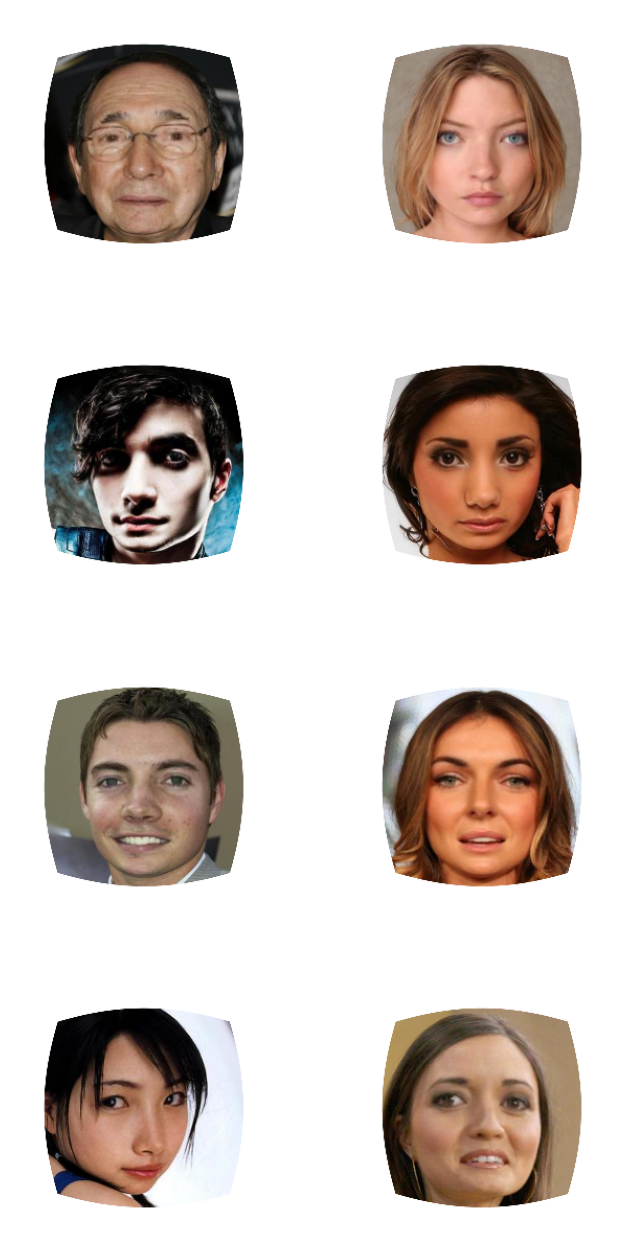

In [ ]:
images = [plt.imread(f'/content/drive/MyDrive/Kaggle/celeba_hq_256/0000{i}.jpg') for i in range(1,9)]
distorted = [fish_eye_distortion(a,0.5,0.2) for a in images]
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(8, 16))

for ax, img in zip(axes.ravel(), distorted):
    ax.imshow(img)
    ax.axis('off')

# Data Preparation

In [ ]:

import os
import sklearn

from sklearn.model_selection import train_test_split
# split dataset into train and test set
images_dir = '/content/drive/MyDrive/Kaggle/celeba_hq_256'
images = os.listdir(images_dir)
train, test = train_test_split(images,test_size=0.2,random_state=42)
train = train[:5000]

#original_train, distorted_train = train_test_split(train,test_size=0.5,random_state=42)

base_dir = '/content/drive/MyDrive/Kaggle'
# create folders for original and distored images
for folder in ['original_train', 'distorted_train','original_test', 'distorted_test']:
    if not os.path.exists(f'{base_dir}/{folder}'):
        os.mkdir(f'{base_dir}/{folder}')

In [ ]:

import shutil
for img in train:
  source_path = os.path.join(images_dir, img)
  target_path = os.path.join(base_dir, 'original_train', img)
  if not os.path.exists(target_path):
    shutil.copy(source_path, target_path)

for img in test:
  source_path = os.path.join(images_dir, img)
  target_path = os.path.join(base_dir, 'original_test', img)
  if not os.path.exists(target_path):
    shutil.copy(source_path, target_path)

In [ ]:

# distort remaining train images and save in distorted_train folder
for img in train:
    if not os.path.exists(f'{base_dir}/distorted_train/{img}'):
        arr = plt.imread(f'{images_dir}/{img}')
        k1, k2 = np.random.uniform(size=2)
        distorted = fish_eye_distortion(arr,k1,k2)
        plt.imsave(f'{base_dir}/distorted_train/{img}', distorted)

# distort test images and save in distorted_test folder
for img in test:
    if not os.path.exists(f'{base_dir}/distorted_test/{img}'):
        arr = plt.imread(f'{images_dir}/{img}')
        k1, k2 = np.random.uniform(size=2)
        distorted = fish_eye_distortion(arr,k1,k2)
        plt.imsave(f'{base_dir}/distorted_test/{img}', distorted)


In [ ]:
base_dir = '/content/drive/MyDrive/Kaggle'

In [ ]:
distorted_train= tf.keras.utils.image_dataset_from_directory(f'{base_dir}/distorted_train',labels=None,batch_size=16,shuffle=False)
original_train= tf.keras.utils.image_dataset_from_directory(f'{base_dir}/original_train',labels=None,batch_size=16,shuffle=False)

Found 5000 files belonging to 1 classes.
Found 5000 files belonging to 1 classes.


In [ ]:
# normalize original and distorted train images
original_train = original_train.map(lambda x: x / 255.)

distorted_train = distorted_train.map(lambda x: x / 255.)

In [ ]:
global numl
numl = [0]

In [ ]:
def save_result_images(image,index, x):
  path = f'/content/drive/MyDrive/Kaggle/First 100/{index+x}.jpg'
  if os.path.exists(path):
    x += 1
    save_result_images(image,index, x)
  else:
    tf.keras.preprocessing.image.save_img(f'/content/drive/MyDrive/Kaggle/First 100/{index+x}.jpg',image)

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    x=14
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image)
        save_result_images(image, index, numl[-1])
        numl[-1] += 1
        plt.axis("off")

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input, decode_predictions
from tensorflow.keras import Input
from tensorflow.keras.preprocessing import image
from sklearn.metrics.pairwise import cosine_similarity

input_tensor = Input(shape=(256, 256, 3))
model = ResNet50(input_tensor=input_tensor, include_top=False, weights='imagenet', pooling='avg')

def similarity(img_name,generator):
    original_img = image.load_img(f'{base_dir}/original_test/{img_name}', target_size=(256, 256))
    distorted_img = image.load_img(f'{base_dir}/distorted_test/{img_name}', target_size=(256, 256))
    orig_array = image.img_to_array(original_img)
    orig_array = np.expand_dims(orig_array, axis=0)
    orig_array = preprocess_input(orig_array)
    dist_array = image.img_to_array(distorted_img)/255.
    dist_array = np.expand_dims(dist_array, axis=0)
    corr_array = generator(dist_array)*255
    corr_array = preprocess_input(corr_array)
    orig_embeddings = model.predict(orig_array,verbose=0)
    corr_embeddings = model.predict(corr_array,verbose=0)
    return cosine_similarity(orig_embeddings,corr_embeddings)

def avg_similarity(img_paths,generator):
    similarities = []
    for img_name in img_paths:
        similarities.append(similarity(img_name,generator)[0][0])
    return np.mean(similarities)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
def save_history(losses, scores):
    # Convert float32 to float for JSON serialization
    losses = {k: [float(val) for val in v] for k, v in losses.items()}
    scores = [float(val) for val in scores]

    with open('losses.json', 'w') as f:
        json.dump(losses, f)

    with open('scores.json', 'w') as f:
        json.dump(scores, f)

# Training

In [ ]:
from tensorflow.keras import Input
from tensorflow.keras.models import save_model, load_model, Model
input_shape = (256,256,3)
d_opt = keras.optimizers.Adam(learning_rate = 0.0001)
g_opt = keras.optimizers.Adam(learning_rate = 0.0001)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
#gan.compile(loss=cross_entropy, optimizer=g_opt)


def create_generator(input_shape):
    generator = Sequential([
        Conv2D(64, kernel_size=4, strides=2, padding="SAME", activation=LeakyReLU(0.2), input_shape=input_shape),
        BatchNormalization(),
        Conv2D(128, kernel_size=4, strides=2, padding="SAME", activation=LeakyReLU(0.2)),
        BatchNormalization(),
        Conv2D(256, kernel_size=4, strides=2, padding="SAME", activation=LeakyReLU(0.2)),
        BatchNormalization(),
        Conv2D(512, kernel_size=4, strides=2, padding="SAME", activation=LeakyReLU(0.2)),
        BatchNormalization(),
        Conv2D(512, kernel_size=4, padding="SAME", activation=LeakyReLU(0.2)),
        BatchNormalization(),
        Dropout(0.2),
        Conv2DTranspose(512, kernel_size=4, strides=2, padding="SAME", activation=LeakyReLU(0.2)),
        BatchNormalization(),
        Conv2DTranspose(256, kernel_size=4, strides=2, padding="SAME", activation=LeakyReLU(0.2)),
        BatchNormalization(),
        Conv2DTranspose(128, kernel_size=4, strides=2, padding="SAME", activation=LeakyReLU(0.2)),
        BatchNormalization(),
        Conv2DTranspose(64, kernel_size=4, strides=2, padding="SAME", activation=LeakyReLU(0.2)),
        BatchNormalization(),
        Conv2DTranspose(3, kernel_size=4, padding="SAME", activation="tanh")
    ])
    return generator

# Function to create the discriminator model
def create_discriminator(input_shape):
    discriminator = Sequential([
        Conv2D(64, kernel_size=4, strides=2, padding="SAME", activation=LeakyReLU(0.2), input_shape=input_shape),
        Conv2D(128, kernel_size=4, strides=2, padding="SAME", activation=LeakyReLU(0.2)),
        BatchNormalization(),
        Conv2D(128, kernel_size=4, strides=2, padding="SAME", activation=LeakyReLU(0.2)),
        BatchNormalization(),
        Flatten(),
        Dropout(0.2),
        Dense(1, activation="sigmoid")
    ])
    discriminator.compile(loss="binary_crossentropy", optimizer=d_opt)
    return discriminator


def create_gan(generator, discriminator):
    discriminator.trainable = False

    gan_input = Input(shape=(input_shape))
    generator_output = generator(gan_input)
    gan_output = discriminator(generator_output)

    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=g_opt)

    discriminator.trainable = True
    return gan

def save(gan, generator, discriminator):
    discriminator.trainable = False
    save_model(gan, 'gan')
    discriminator.trainable = True
    save_model(generator, 'generator')
    save_model(discriminator, 'discriminator')


def load():
    discriminator = load_model('discriminator')
    generator = load_model('generator')
    gan = load_model('gan')
    return gan, generator, discriminator

In [ ]:
# Create and compile the models
input_shape = (256,256,3)
generator = create_generator(input_shape)
discriminator = create_discriminator(input_shape)
#gan = tf.keras.models.load_model("/content/drive/MyDrive/Kaggle/gan160.h5")
gan = create_gan(generator,discriminator)

In [ ]:
#gan, generator, discriminator = load()

In [ ]:
# input_shape = (256,256,3)
# d_opt = keras.optimizers.Adam(2e-4, beta_1=0.5) #learning_rate = 0.0001
# g_opt = keras.optimizers.Adam(2e-4, beta_1=0.5) #learning_rate = 0.001
# cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# gan.compile(loss=cross_entropy, optimizer=g_opt)
# discriminator.compile(loss=cross_entropy, optimizer=d_opt)
# generator.compile(loss = cross_entropy, optimizer=g_opt)

In [ ]:
scores = []
losses = {'disc':[],'gen':[]}

In [ ]:
import os
import json
def train_gan(gan, gen, disc, dist_dataset, orig_dataset, scores, n_epochs=30):
    for epoch in range(n_epochs):
        print("Epoch {}".format(epoch + 1),end=" ")
        for X_batch_dist, X_batch_orig in tf.data.Dataset.zip((dist_dataset,orig_dataset)):
            # phase 1 - training the discriminator
            generated_images = gen(X_batch_dist)
            X_fake_and_real = tf.concat([generated_images, X_batch_orig], axis=0)
            batch_size = tf.shape(X_batch_dist)[0]
            y1 = tf.concat([zeros((batch_size,1)), ones((batch_size,1))],axis=0)
            disc.trainable = True
            d_loss = disc.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            y2 = ones((batch_size,1))
            disc.trainable = False
            g_loss = gan.train_on_batch(X_batch_dist, y2)
        print(f'========> D_Loss: {d_loss},  G_Loss:{g_loss}')
        # Calculate similarity score for random images after each 10 epochs
        if ((epoch+1)%10==0):
            paths = np.random.choice(os.listdir('/content/drive/MyDrive/Kaggle/distorted_test'),32,replace=False)
            scores.append(avg_similarity(paths,generator))
        losses['gen'].append(g_loss)
        losses['disc'].append(d_loss)
        save_history(losses, scores)
        #plot images after each 10 epochs
        if ((epoch+1)%10==0):
            plot_multiple_images(generated_images, 8)
            plt.show()
            # Save gan model and training history at the end of each epoch
            gan.save(f'gan{epoch+101}.h5')

In [ ]:
"/content/drive/MyDrive/Kaggle/distorted_train/23936.jpg"

Epoch 1 ========> D_Loss: 2.7523738026502542e-06,  G_Loss:1.74890191217969e-09
Epoch 2 ========> D_Loss: 4.363485992615792e-16,  G_Loss:8.315180565176801e-16
Epoch 3 ========> D_Loss: 5.110996348367536e-11,  G_Loss:2.8252155971131288e-05
Epoch 4 ========> D_Loss: 7.857117452658713e-06,  G_Loss:0.8239565491676331
Epoch 5 ========> D_Loss: 1.7765775326023842e-34,  G_Loss:2.2661516442656737e-35
Epoch 6 ========> D_Loss: 1.9043543597521e-14,  G_Loss:3.790595292230137e-05
Epoch 7 ========> D_Loss: 2.5214188782663946e-14,  G_Loss:9.664543176768348e-05
Epoch 8 ========> D_Loss: 5.396974742293047e-28,  G_Loss:5.539504150792397e-28
Epoch 9 ========> D_Loss: 0.8500364422798157,  G_Loss:0.035025455057621
Epoch 10 ========> D_Loss: 1.9670628148560354e-07,  G_Loss:3.904682355226896e-09


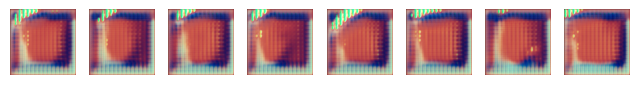

Epoch 11 ========> D_Loss: 3.7117992909030756e-17,  G_Loss:3.519654829902113e-16
Epoch 12 ========> D_Loss: 1.648767577772379e-20,  G_Loss:0.0
Epoch 13 ========> D_Loss: 2.9333349026384137e-25,  G_Loss:0.0023892116732895374
Epoch 14 ========> D_Loss: 4.40874962179152e-19,  G_Loss:2.3733224519223266e-14
Epoch 15 ========> D_Loss: 9.408259726839674e-10,  G_Loss:4.941598892211914
Epoch 16 ========> D_Loss: 2.958191223957811e-19,  G_Loss:5.510049881640722e-13
Epoch 17 ========> D_Loss: 0.7844762802124023,  G_Loss:0.007232618052512407
Epoch 18 ========> D_Loss: 0.0417725145816803,  G_Loss:91.01459503173828
Epoch 19 ========> D_Loss: 1.1775715125228459e-10,  G_Loss:0.8891512155532837
Epoch 20 ========> D_Loss: 0.00011359511699993163,  G_Loss:1.385165493417162e-08


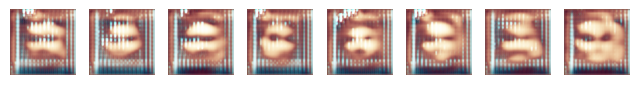

Epoch 21 ========> D_Loss: 0.6774603128433228,  G_Loss:111.83955383300781
Epoch 22 ========> D_Loss: 4.9997296057777696e-36,  G_Loss:1.102327585220337
Epoch 23 ========> D_Loss: 7.412785489957716e-30,  G_Loss:1.3671631846914022e-14
Epoch 24 ========> D_Loss: 1.3526950393139003e-11,  G_Loss:3.470469067679005e-08
Epoch 25 ========> D_Loss: 1.6375171441040948e-08,  G_Loss:4.3409616924824056e-15
Epoch 26 ========> D_Loss: 4.371988932856804e-15,  G_Loss:0.5112844109535217
Epoch 27 ========> D_Loss: 0.568870484828949,  G_Loss:1.3743856186465564e-07
Epoch 28 ========> D_Loss: 3.741609141114967e-14,  G_Loss:5.806051195378359e-10
Epoch 29 ========> D_Loss: 3.525956291808542e-17,  G_Loss:2.2176291496624307e-30
Epoch 30 ========> D_Loss: 1.1636227537081822e-09,  G_Loss:1.9107351303100586


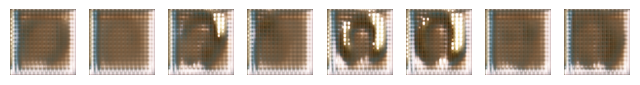

Epoch 31 ========> D_Loss: 0.0005287039675749838,  G_Loss:9.971057757240942e-09
Epoch 32 ========> D_Loss: 0.9582811594009399,  G_Loss:7.553706495855295e-07
Epoch 33 ========> D_Loss: 3.7082137490859757e-13,  G_Loss:8.448962034890428e-06
Epoch 34 ========> D_Loss: 1.665140421380773e-11,  G_Loss:8.876149513525888e-05
Epoch 35 ========> D_Loss: 1.0688740948654012e-14,  G_Loss:0.00023195870744530112
Epoch 36 ========> D_Loss: 4.391147971090749e-15,  G_Loss:0.011279065161943436
Epoch 37 ========> D_Loss: 4.963597802998265e-06,  G_Loss:0.8613758087158203
Epoch 38 ========> D_Loss: 1.4312203691406397e-20,  G_Loss:7.818417678441999e-18
Epoch 39 ========> D_Loss: 1.5523208451269733e-18,  G_Loss:5.469900214479611e-17
Epoch 40 ========> D_Loss: 9.030872543221996e-24,  G_Loss:44.72475814819336


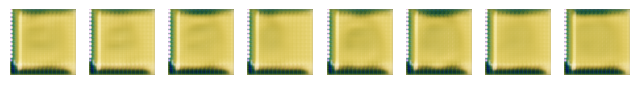

Epoch 41 ========> D_Loss: 6.626343224125364e-11,  G_Loss:0.18360862135887146
Epoch 42 ========> D_Loss: 2.7754927804830853e-13,  G_Loss:1.6635171175003052
Epoch 43 ========> D_Loss: 3.066931270590205e-17,  G_Loss:0.0
Epoch 44 ========> D_Loss: 7.383656708270792e-08,  G_Loss:2.003587340482227e-08
Epoch 45 ========> D_Loss: 6.846679039690384e-12,  G_Loss:1.7581951397005469e-06
Epoch 46 ========> D_Loss: 0.0,  G_Loss:0.0
Epoch 47 ========> D_Loss: 9.768041294617945e-37,  G_Loss:1.5788309053487476e-28
Epoch 48 ========> D_Loss: 4.267112325609375e-20,  G_Loss:1.3491334785453724e-11
Epoch 49 ========> D_Loss: 3.865236074091349e-30,  G_Loss:1.0190653479495212e-23
Epoch 50 ========> D_Loss: 6.300833745956468e-22,  G_Loss:5.242901011115464e-07


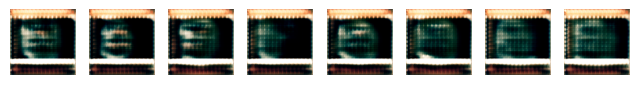

Epoch 51 ========> D_Loss: 6.569095201003762e-17,  G_Loss:1.2989049075819723e-15
Epoch 52 ========> D_Loss: 1.3936004129859911e-21,  G_Loss:6.302769151034227e-08
Epoch 53 ========> D_Loss: 3.4376874177149963e-13,  G_Loss:0.0747280940413475
Epoch 54 ========> D_Loss: 1.9037398715227027e-06,  G_Loss:0.00023152008361648768
Epoch 55 ========> D_Loss: 6.4558276141127455e-25,  G_Loss:6.556668949997402e-07
Epoch 56 ========> D_Loss: 0.0,  G_Loss:1.1381428785539605e-11
Epoch 57 ========> D_Loss: 2.013198141526118e-08,  G_Loss:1.627843976020813
Epoch 58 ========> D_Loss: 9.76792224747945e-26,  G_Loss:2.4052119371781624e-19
Epoch 59 ========> D_Loss: 6.53895008491111e-22,  G_Loss:2.5522103258441013e-16
Epoch 60 ========> D_Loss: 7.142345799804699e-19,  G_Loss:0.00018757460929919034


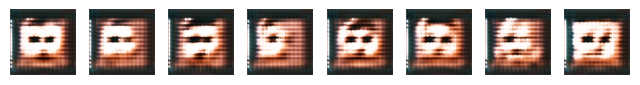

Epoch 61 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-2555b8050aa1>", line 2, in <cell line: 2>
    train_gan(gan, generator, discriminator, distorted_train, original_train,scores, 200)
  File "<ipython-input-21-0c487c3086df>", line 6, in train_gan
    for X_batch_dist, X_batch_orig in tf.data.Dataset.zip((dist_dataset,orig_dataset)):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 810, in __next__
    return self._next_internal()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 773, in _next_internal
    ret = gen_dataset_ops.iterator_get_next(
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 3029, in iterator_get_next
    _ops.raise_from_not_ok_status(e, name)
  File "/usr/loc

In [ ]:
# train for 100 epochs
train_gan(gan, generator, discriminator, distorted_train, original_train,scores, 100)

In [ ]:
#Epoch 100 ========> D_Loss: 1.5878101827409028e-20,  G_Loss:6.147416788872154e-16

In [ ]:
# Save the model
save(gan,generator,discriminator)

In [ ]:
def plot_losses(losses):
    disc_losses = losses['disc']
    gen_losses = losses['gen']
    plt.figure(figsize=(10, 6))
    plt.plot(disc_losses, label='Discriminator Loss', color='blue')
    plt.plot(gen_losses, label='Generator Loss', color='red')
    plt.title('Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

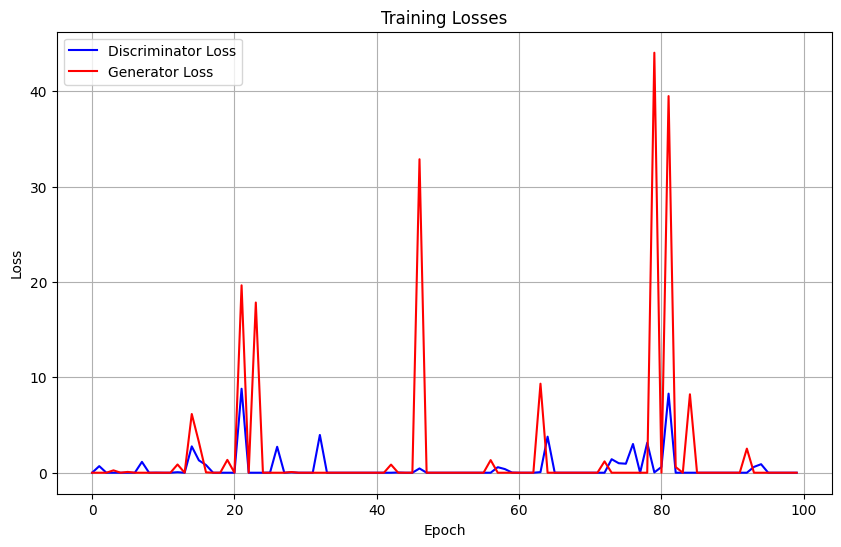

In [ ]:
plot_losses(losses)

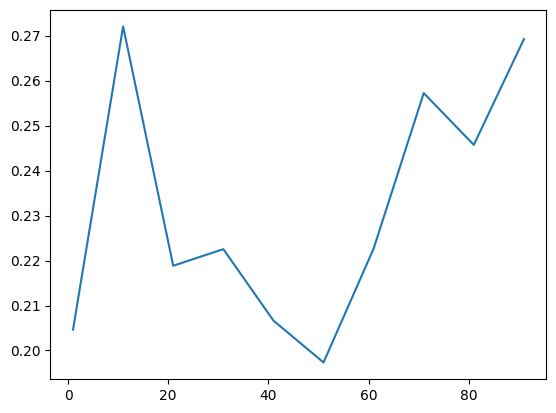

In [ ]:
plt.plot(range(1,101,10),scores);